# FENE beadspring with variable kuhn length experiment data analysis

In [62]:
import os

import polyflexmd.data_analysis.data.read as read
import polyflexmd.data_analysis.transform.transform as transform
import polyflexmd.data_analysis.theory.kremer_grest as kremer_grest
import polyflexmd.data_analysis.theory.rouse as rouse
import polyflexmd.data_analysis.plot.plot_system as plot_system
import polyflexmd.experiment_runner.config as config
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from pandarallel import pandarallel
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sns.set_style("darkgrid")

In [4]:
pandarallel.initialize(
    nb_workers=len(os.sched_getaffinity(0)),
    progress_bar=False,
    use_memory_fs=False
)

INFO: Pandarallel will run on 128 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## Read and process data

In [5]:
PATH_EXPERIMENT = "/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results/FENE-beadspring-vary-l_K/4-FENE-beadspring-vary-l_K-equilibrate/9f6e664e"
NAME_EC = "4-FENE-beadspring-vary-l_K-equilibrate.toml"

In [6]:
PATH_EXPERIMENT = pathlib.Path(PATH_EXPERIMENT)
PATH_SYSTEM_DEF = PATH_EXPERIMENT / "data/initial_system.data"
PATH_EC = PATH_EXPERIMENT / NAME_EC

### Read experiment config

In [7]:
conf = config.read_experiment_config(PATH_EC)
conf

ExperimentConfig(simulation_config=SimulationConfig(job=SlurmJobConfig(account='p_mdpolymer', time='24:00:00', partition='romeo', nodes=8, tasks_per_node=128, ntasks=1024, cpus_per_task=1, mem_per_cpu=1000), simulation_model_path=PosixPath('simulations/FENE-beadspring-vary-l_K.lammps'), experiments_path=PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results'), n_partitions=8, n_tasks_per_partition=128, variables={'kappa_start': 1.0, 'kappa_delta': 5, 'kappa_n_values': 8, 'n_relax_steps': 30000000, 'n_equilibrium_steps': 1000000}), system_creator_config=SystemCreatorConfig(job=SlurmJobConfig(account='p_mdpolymer', time='1:00:00', partition='romeo', nodes=1, tasks_per_node=1, ntasks=1, cpus_per_task=4, mem_per_cpu=1000), venv_path=PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/polyflexmd/.venv'), system_config=AnchoredFENEChainConfig(name='anchored-fene-chain', n_chains=40, n_monomers=128, monomer_type=2, bond_type=1, angle_type=1, bond_length=0.97, box_le

In [8]:
kappas: list[float] = [
    conf.simulation_config.variables["kappa_start"] + conf.simulation_config.variables["kappa_delta"] * i
    for i in range(conf.simulation_config.variables["kappa_n_values"])
]
kappas

[1.0, 6.0, 11.0, 16.0, 21.0, 26.0, 31.0, 36.0]

### Read initial system

In [9]:
system = read.read_lammps_system_data(PATH_SYSTEM_DEF)
system.atoms

,molecule-ID,type,x,y,z,ix,iy,iz
1,1,1,0.000000,0.000000,0.000000,0,0,0
2,1,1,0.764233,-0.425729,-0.419050,0,0,0
3,1,2,0.773821,-0.836732,0.459520,0,0,0
4,1,2,1.285179,-0.524169,-0.303184,0,0,0
5,1,2,0.842282,0.329744,-0.427985,0,0,0
...,...,...,...,...,...,...,...,...
5116,40,2,-8.806796,0.070591,-4.480917,0,0,0
5117,40,2,-8.040260,-0.270179,-3.993886,0,0,0
5118,40,2,-7.295676,-0.582204,-4.531599,0,0,0
5119,40,2,-7.689637,0.070740,-3.932133,0,0,0


In [10]:
system.bonds

,type,atom1,atom2
1,1,1,2
2,1,2,3
3,1,3,4
4,1,4,5
5,1,5,6
...,...,...,...
5076,1,5115,5116
5077,1,5116,5117
5078,1,5117,5118
5079,1,5118,5119


In [11]:
system.angles

,type,atom1,atom2,atom3
1,1,1,2,3
2,1,2,3,4
3,1,3,4,5
4,1,4,5,6
5,1,5,6,7
...,...,...,...,...
5036,1,5114,5115,5116
5037,1,5115,5116,5117
5038,1,5116,5117,5118
5039,1,5117,5118,5119


In [12]:
system.box

-100.000000 100.000000  xlo xhi
-100.000000 100.000000  ylo yhi
-100.000000 100.000000  zlo zhi

### Read and process trajectories

In [13]:
PATH_DATA_PROCESSED = PATH_EXPERIMENT / "data" / "processed"
PATH_DATA_PROCESSED.mkdir(exist_ok=True)
PATH_DF_TRAJECTORY_PROCESSED = PATH_DATA_PROCESSED / "trajectory_unfolded_kappas.csv"
PATH_DF_TRAJECTORY_PROCESSED

PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results/FENE-beadspring-vary-l_K/4-FENE-beadspring-vary-l_K-equilibrate/9f6e664e/data/processed/trajectory_unfolded_kappas.csv')

In [14]:
def read_and_process_kappas_df(experiment_path: pathlib.Path, kappas: list[float]):
    dfs = []
    for i in range(1, len(kappas) + 1):
        paths_trajectories = [
            experiment_path / "data" / f"polymer_relax-{i}.out",
            experiment_path / "data" / f"polymer-{i}.out"
        ]
        print(f"Reading {paths_trajectories}...")
        if not all(p.exists() for p in paths_trajectories):
            break

        df_trajectory_unfolded = transform.unfold_coordinates_df(
            trajectory_df=transform.join_raw_trajectory_df_with_system_data(
                raw_trajectory_df=read.read_multiple_raw_trajectory_dfs(paths_trajectories),
                system_data=system
            ),
            system_data=system
        )
        df_trajectory_unfolded["kappa"] = kappas[i-1]
        dfs.append(df_trajectory_unfolded)

    return pd.concat(dfs)


if PATH_DF_TRAJECTORY_PROCESSED.exists():
    print("Reading processed...")
    df_trajectory_unfolded_kappas = pd.read_csv(PATH_DF_TRAJECTORY_PROCESSED)
else:
    print("Reading and processing...")
    df_trajectory_unfolded_kappas = read_and_process_kappas_df(PATH_EXPERIMENT, kappas)
    print("Writing...")
    df_trajectory_unfolded_kappas.to_csv(PATH_DF_TRAJECTORY_PROCESSED, index=False)

df_trajectory_unfolded_kappas

Reading processed...


,t,id,type,x,y,z,ix,iy,iz,molecule-ID,kappa
0,0,1,1,0.000000,0.000000,0.000000,0,0,0,1,1.0
1,0,2,1,0.764233,-0.425729,-0.419050,0,0,0,1,1.0
2,0,3,2,0.773821,-0.836732,0.459520,0,0,0,1,1.0
3,0,4,2,1.285180,-0.524169,-0.303184,0,0,0,1,1.0
4,0,5,2,0.842282,0.329744,-0.427985,0,0,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...
16465915,31000000,5116,2,38.432100,53.571600,-15.035800,0,0,0,40,36.0
16465916,31000000,5117,2,39.109900,53.909000,-14.508400,0,0,0,40,36.0
16465917,31000000,5118,2,39.853000,54.151200,-13.865600,0,0,0,40,36.0
16465918,31000000,5119,2,40.567100,54.417600,-13.259500,0,0,0,40,36.0


In [15]:
df_trajectory_unfolded_kappas.groupby(["kappa"])["t"].describe()

,count,mean,std,min,25%,50%,75%,max
kappa,,,,,,,,
1.0,2058240.0,1.889428e+07,1.008704e+07,0.0,10000000.0,20050000.0,30000000.0,31000000.0
6.0,2058240.0,1.889428e+07,1.008704e+07,0.0,10000000.0,20050000.0,30000000.0,31000000.0
11.0,2058240.0,1.889428e+07,1.008704e+07,0.0,10000000.0,20050000.0,30000000.0,31000000.0
16.0,2058240.0,1.889428e+07,1.008704e+07,0.0,10000000.0,20050000.0,30000000.0,31000000.0
21.0,2058240.0,1.889428e+07,1.008704e+07,0.0,10000000.0,20050000.0,30000000.0,31000000.0
26.0,2058240.0,1.889428e+07,1.008704e+07,0.0,10000000.0,20050000.0,30000000.0,31000000.0
31.0,2058240.0,1.889428e+07,1.008704e+07,0.0,10000000.0,20050000.0,30000000.0,31000000.0
36.0,2058240.0,1.889428e+07,1.008704e+07,0.0,10000000.0,20050000.0,30000000.0,31000000.0


## Calculate and plot observables relax+equi

In [16]:
l_b_src = .97
L_src = l_b_src*(conf.system_creator_config.system_config.n_monomers-1)
L_src

123.19

### End-to-End distance $\vec{R}$

In [17]:
PATH_ETE = PATH_EXPERIMENT / "data" / "processed" / "ete.csv"

if PATH_ETE.exists():
    print("Reading processed...")
    df_ete = pd.read_csv(PATH_ETE, index_col=["kappa", "t", "molecule-ID"])
else:
    print("Processing...")
    df_ete = df_trajectory_unfolded_kappas.groupby("kappa").apply(transform.calc_end_to_end_df)
    print("Writing...")
    df_ete.to_csv(PATH_ETE, index=True)

df_ete

Reading processed...


R_x        R_y       R_z          R
kappa t        molecule-ID                                          
1.0   0        1             9.84474  -2.701840   7.54827  12.696268
      100000   1             4.56569  -2.312170   4.62876   6.900513
      200000   1             8.70085  -0.304928  14.06710  16.543309
      300000   1             9.51586  -2.872870  12.65390  16.091183
      400000   1             9.43499   5.311010   1.38062  10.914760
...                              ...        ...       ...        ...
36.0  30960000 40           47.32410  53.151400 -17.23800  73.224247
      30970000 40           45.53370  53.910200 -17.43320  72.687990
      30980000 40           42.11410  55.309700 -13.21120  70.762251
      30990000 40           43.90670  53.552700 -16.09230  71.096077
      31000000 40           41.20860  54.814600 -12.61590  69.727685

[128320 rows x 4 columns]

In [18]:
df_ete["t/LJ"] = df_ete.index.get_level_values("t").map(lambda x: x * 0.0025)
df_ete["R^2"] = df_ete["R"] ** 2
df_ete

R_x        R_y       R_z          R     t/LJ  \
kappa t        molecule-ID                                                      
1.0   0        1             9.84474  -2.701840   7.54827  12.696268      0.0   
      100000   1             4.56569  -2.312170   4.62876   6.900513    250.0   
      200000   1             8.70085  -0.304928  14.06710  16.543309    500.0   
      300000   1             9.51586  -2.872870  12.65390  16.091183    750.0   
      400000   1             9.43499   5.311010   1.38062  10.914760   1000.0   
...                              ...        ...       ...        ...      ...   
36.0  30960000 40           47.32410  53.151400 -17.23800  73.224247  77400.0   
      30970000 40           45.53370  53.910200 -17.43320  72.687990  77425.0   
      30980000 40           42.11410  55.309700 -13.21120  70.762251  77450.0   
      30990000 40           43.90670  53.552700 -16.09230  71.096077  77475.0   
      31000000 40           41.20860  54.814600 -12.61590  69.727685  77500.0   

                                    R^2  
kappa t        molecule-ID               
1.0   0        1             161.195225  
      100000   1              47.617074  
      200000   1             273.681074  
      300000   1             258.926159  
      400000   1             119.131975  
...                                 ...  
36.0  30960000 40           5361.790407  
      30970000 40           5283.543962  
      30980000 40           5007.296138  
      30990000 40           5054.652101  
      31000000 40           4861.950020  

[128320 rows x 6 columns]

In [19]:
df_ete_mean = df_ete.groupby(["kappa", "t"])[["R^2"]].mean()
df_ete_mean["l_K"] = kremer_grest.bare_kuhn_length(
    np.array(df_ete_mean.index.get_level_values("kappa")),
    l_b=l_b_src
)
df_ete_mean

R^2        l_K
kappa t                               
1.0   0          126.013356   1.854017
      100000     157.981801   1.854017
      200000     166.871239   1.854017
      300000     189.227254   1.854017
      400000     169.838735   1.854017
...                     ...        ...
36.0  30960000  5848.760377  68.870000
      30970000  5894.324445  68.870000
      30980000  5970.267187  68.870000
      30990000  5944.186949  68.870000
      31000000  5896.035117  68.870000

[3208 rows x 2 columns]

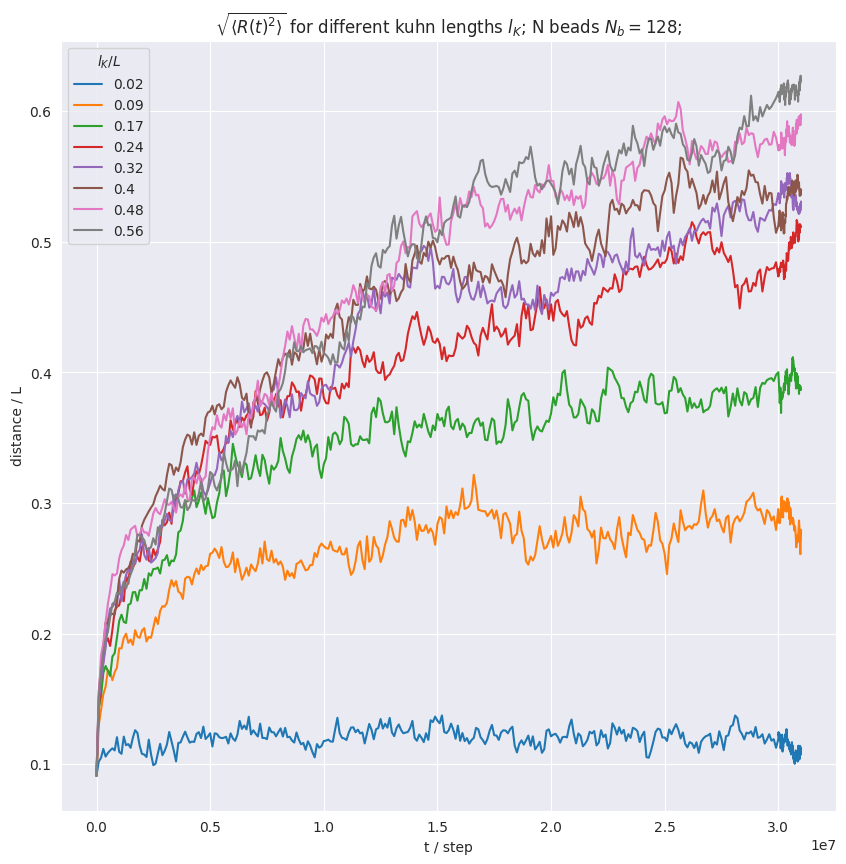

In [20]:
kappa_colors = sns.color_palette(n_colors=len(kappas))

ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(10,10))
ax.set(
    title=f'$\sqrt{{\\langle R(t)^2 \\rangle }}$ for different kuhn lengths $l_K$; '
          f'N beads $N_b={conf.system_creator_config.system_config.n_monomers}$;',
    ylabel="distance / L",
    xlabel="t / step"
)

sns.lineplot(
    x=df_ete_mean.index.get_level_values("t"),
    y=np.sqrt(df_ete_mean["R^2"]) / L_src,
    hue=(df_ete_mean["l_K"]/L_src).round(2).astype("category"),
    color=kappa_colors,
    ax=ax
)

ax.get_legend().set_title("$l_K/L$")

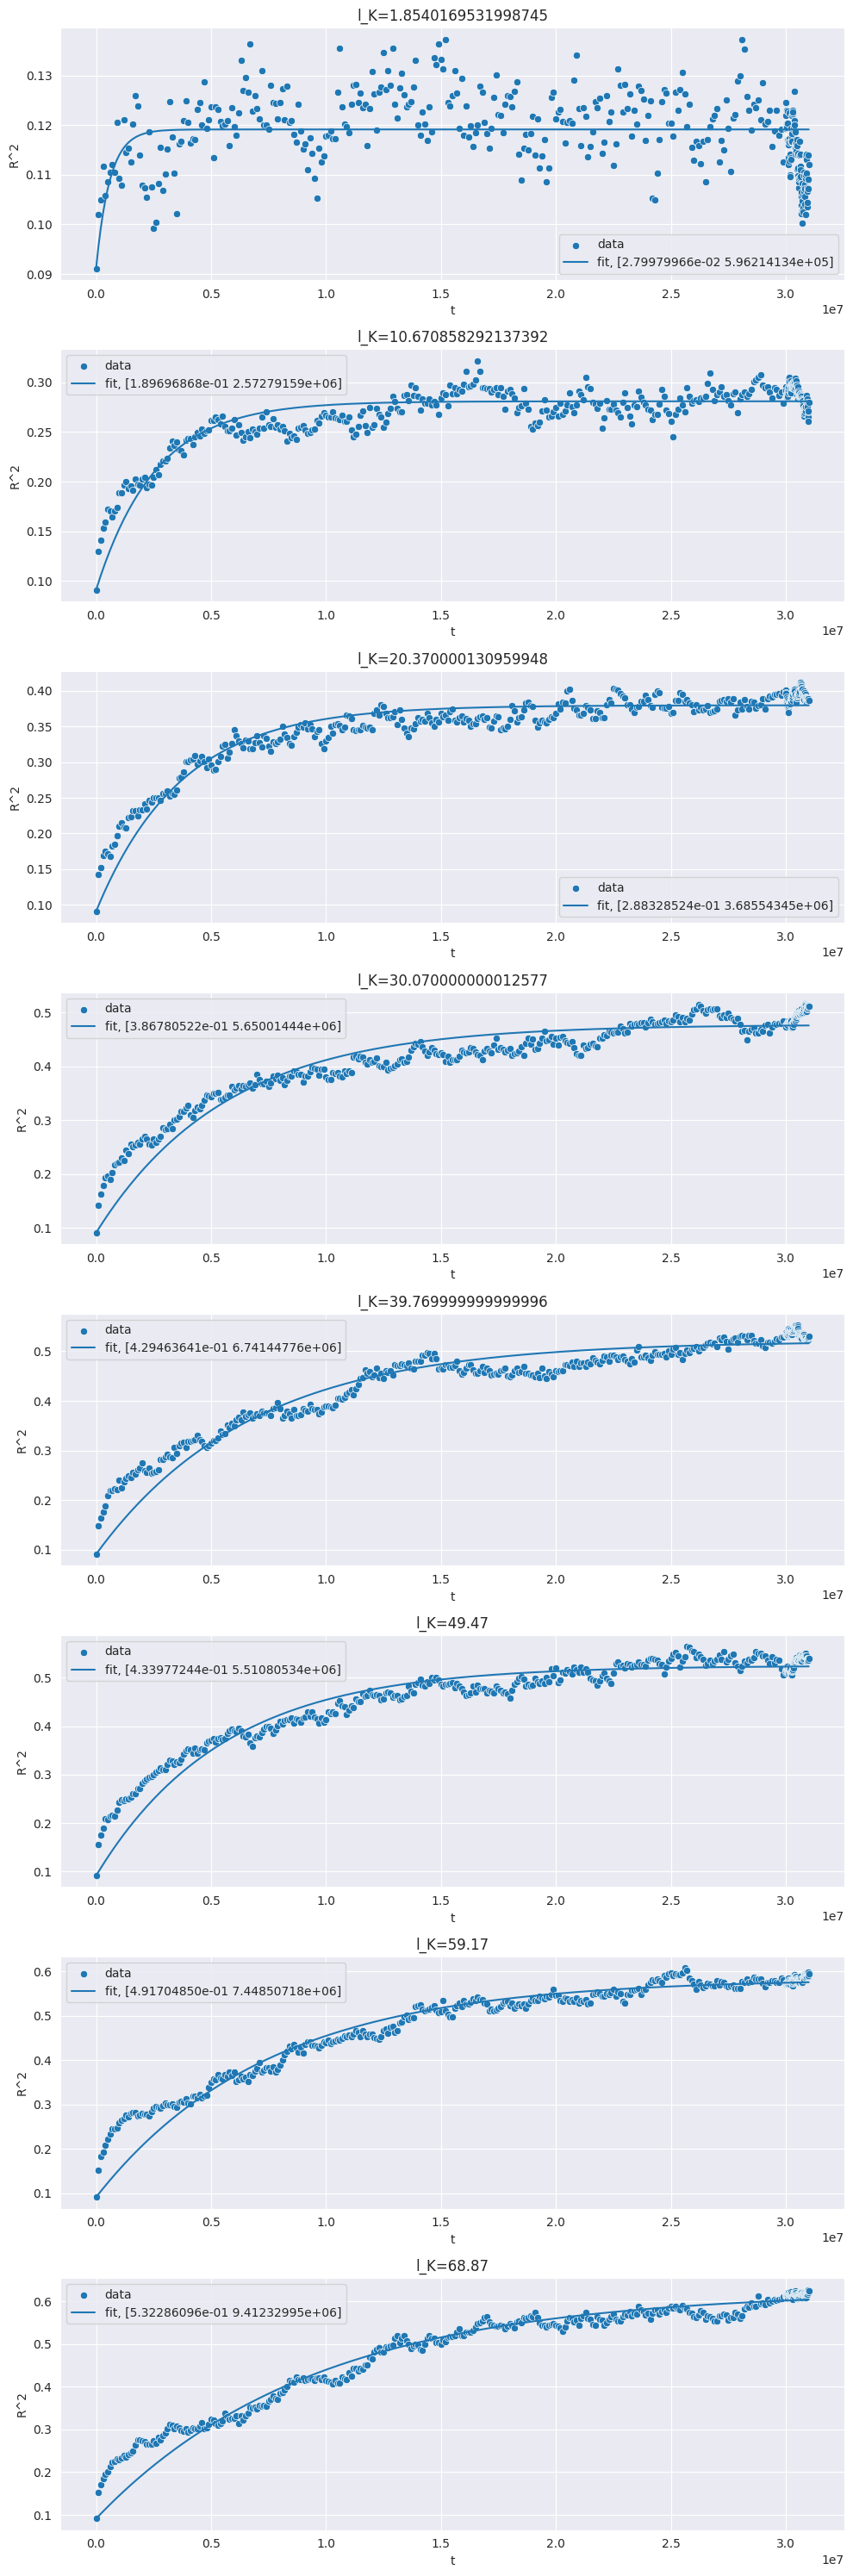

In [21]:
import scipy.optimize
import functools

axs: list[plt.Axes]
fig: plt.Figure
fig, axs = plt.subplots(nrows=len(kappas), figsize=(10,30))

estimated_R_sq = []

def f_relax(ts, A, tau, eps):
    return A*(1-np.exp(-ts/tau))+eps

for (l_K, df_ete_mean_l_K), ax in zip(df_ete_mean.groupby("l_K"), axs):

    ax.set_title(f"l_K={l_K}")

    eps = np.sqrt(df_ete_mean_l_K.loc[pd.IndexSlice[:, 0], :]["R^2"].iloc[0])/L_src
    popt, pcov = scipy.optimize.curve_fit(
        functools.partial(f_relax, eps=eps),
        df_ete_mean_l_K.index.get_level_values("t"),
        np.sqrt(df_ete_mean_l_K["R^2"]) / L_src,
        p0=(.5, 1e4)
    )
    estimated_R_sq.append((popt[0]*L_src)**2)

    sns.scatterplot(
        x=df_ete_mean_l_K.index.get_level_values("t"),
        y=np.sqrt(df_ete_mean_l_K["R^2"]) / L_src,
        ax=ax,
        label="data"
    )
    sns.lineplot(
        x=df_ete_mean_l_K.index.get_level_values("t"),
        y=f_relax(df_ete_mean_l_K.index.get_level_values("t"), *popt, eps),
        ax=ax,
        label=f"fit, {popt}"
    )
fig.tight_layout()

## Equilibrium statistics

In [22]:
t_equilibrium = conf.simulation_config.variables["n_relax_steps"]
t_equilibrium

30000000

In [23]:
df_trajectory_unfolded_kappas_equi = df_trajectory_unfolded_kappas.loc[df_trajectory_unfolded_kappas["t"] > t_equilibrium]
df_trajectory_unfolded_kappas_equi

,t,id,type,x,y,z,ix,iy,iz,molecule-ID,kappa
1546240,30010000,1,1,0.000000,0.000000,0.000000,0,0,0,1,1.0
1546241,30010000,2,1,0.764233,-0.425729,-0.419050,0,0,0,1,1.0
1546242,30010000,3,2,-0.101061,-0.700491,-0.284084,0,0,0,1,1.0
1546243,30010000,4,2,0.139373,-1.563080,-0.808157,0,0,0,1,1.0
1546244,30010000,5,2,0.879174,-1.102080,-0.384745,0,0,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...
16465915,31000000,5116,2,38.432100,53.571600,-15.035800,0,0,0,40,36.0
16465916,31000000,5117,2,39.109900,53.909000,-14.508400,0,0,0,40,36.0
16465917,31000000,5118,2,39.853000,54.151200,-13.865600,0,0,0,40,36.0
16465918,31000000,5119,2,40.567100,54.417600,-13.259500,0,0,0,40,36.0


In [24]:
df_ete_kappas_equi = df_ete.iloc[df_ete.index.get_level_values("t") >= t_equilibrium]
df_ete_kappas_equi

R_x        R_y        R_z          R  \
kappa t        molecule-ID                                              
1.0   30000000 1            -8.78463  -5.270250  -0.923965  10.285863   
      30010000 1            -9.89874  -2.687310  -1.740400  10.403638   
      30020000 1            -9.46715  -0.254569  -1.534550   9.594091   
      30030000 1           -11.10030  -3.482280  -3.184430  12.061655   
      30040000 1           -11.24480   1.612500  -8.517860  14.198578   
...                              ...        ...        ...        ...   
36.0  30960000 40           47.32410  53.151400 -17.238000  73.224247   
      30970000 40           45.53370  53.910200 -17.433200  72.687990   
      30980000 40           42.11410  55.309700 -13.211200  70.762251   
      30990000 40           43.90670  53.552700 -16.092300  71.096077   
      31000000 40           41.20860  54.814600 -12.615900  69.727685   

                               t/LJ          R^2  
kappa t        molecule-ID                        
1.0   30000000 1            75000.0   105.798971  
      30010000 1            75025.0   108.235681  
      30020000 1            75050.0    92.046578  
      30030000 1            75075.0   145.483529  
      30040000 1            75100.0   201.599622  
...                             ...          ...  
36.0  30960000 40           77400.0  5361.790407  
      30970000 40           77425.0  5283.543962  
      30980000 40           77450.0  5007.296138  
      30990000 40           77475.0  5054.652101  
      31000000 40           77500.0  4861.950020  

[32320 rows x 6 columns]

In [25]:
df_ete_mean_equi = df_ete_mean.iloc[df_ete_mean.index.get_level_values("t") > t_equilibrium]
df_ete_mean_equi

R^2        l_K
kappa t                               
1.0   30010000   235.239645   1.854017
      30020000   225.434016   1.854017
      30030000   229.229492   1.854017
      30040000   219.257132   1.854017
      30050000   216.857484   1.854017
...                     ...        ...
36.0  30960000  5848.760377  68.870000
      30970000  5894.324445  68.870000
      30980000  5970.267187  68.870000
      30990000  5944.186949  68.870000
      31000000  5896.035117  68.870000

[800 rows x 2 columns]

### Mean bond length

In [26]:
l_b_df = transform.extract_bond_lengths_df_kappas(df_trajectory_unfolded_kappas_equi, t_equilibrium=conf.simulation_config.variables["n_relax_steps"])
l_b_df

,,l_b
kappa,i,
1.0,0,0.970000
6.0,0,0.970000
11.0,0,0.970000
16.0,0,0.970000
21.0,0,0.970000
...,...,...
16.0,507999,0.990229
21.0,507999,1.017665
26.0,507999,0.969010


In [27]:
l_b_df.groupby("kappa").describe()

l_b                                                              \
          count      mean       std       min       25%       50%       75%   
kappa                                                                         
1.0    508000.0  0.970112  0.033314  0.856019  0.946736  0.968029  0.990933   
6.0    508000.0  0.970126  0.033298  0.859428  0.946788  0.968160  0.990930   
11.0   508000.0  0.970212  0.033332  0.857778  0.946829  0.968146  0.991071   
16.0   508000.0  0.970049  0.033272  0.859810  0.946668  0.968031  0.990899   
21.0   508000.0  0.970100  0.033297  0.855617  0.946754  0.968065  0.990930   
26.0   508000.0  0.970136  0.033357  0.853333  0.946692  0.968063  0.990893   
31.0   508000.0  0.970153  0.033309  0.849464  0.946792  0.968147  0.990950   
36.0   508000.0  0.970171  0.033336  0.850580  0.946781  0.968151  0.990984   

                 
            max  
kappa            
1.0    1.166750  
6.0    1.166118  
11.0   1.185414  
16.0   1.167721  
21.0   1.167151  
26.0   1.176952  
31.0   1.174762  
36.0   1.154102

In [28]:
l_b = conf.system_creator_config.system_config.bond_length
l_b

0.97

### Mean contour length

In [29]:
L_contour = l_b*(conf.system_creator_config.system_config.n_monomers-1)
L_contour

123.19

### Kuhn lengths

Svaneborg (8)

In [30]:
l_ks = kremer_grest.bare_kuhn_length(np.array(kappas), l_b)
l_ks

array([ 1.85401695, 10.67085829, 20.37000013, 30.07      , 39.77      ,
       49.47      , 59.17      , 68.87      ])

In [31]:
l_ks / L_contour

array([0.01505006, 0.08662114, 0.16535433, 0.24409449, 0.32283465,
       0.4015748 , 0.48031496, 0.55905512])

### Number of Kuhn segments $N_K$

Estimate $N_K = L / l_K$ as in Svaneborg (6)

In [32]:
N_Ks = (L_contour / l_ks)
N_Ks

array([66.44491561, 11.54452591,  6.04761901,  4.09677419,  3.09756098,
        2.49019608,  2.08196721,  1.78873239])

### End-to-End distance squared $\langle R^2 \rangle$

Estimate $\langle R^2 \rangle$ as average over ensemble and then over time in equilibrium

In [36]:
df_ete_sq_t_mean_kappas = transform.calculate_ete_sq_t_avg_df_kappas(df_ete_mean_equi, t_equilibrium)
df_ete_sq_t_mean_kappas

,R^2
kappa,
1.0,194.621441
6.0,1256.268163
11.0,2336.101272
16.0,3706.708372
21.0,4363.209138
26.0,4299.076533
31.0,5134.214930
36.0,5753.812169


### Summarize statistics by kappas

In [40]:
df_kuhn_summary = pd.DataFrame({
    "R^2": df_ete_sq_t_mean_kappas["R^2"],
    "N_K": N_Ks,
    "l_K": l_ks
}, index=df_ete_sq_t_mean_kappas.index)
df_kuhn_summary

,R^2,N_K,l_K
kappa,,,
1.0,194.621441,66.444916,1.854017
6.0,1256.268163,11.544526,10.670858
11.0,2336.101272,6.047619,20.370000
16.0,3706.708372,4.096774,30.070000
21.0,4363.209138,3.097561,39.770000
26.0,4299.076533,2.490196,49.470000
31.0,5134.214930,2.081967,59.170000
36.0,5753.812169,1.788732,68.870000


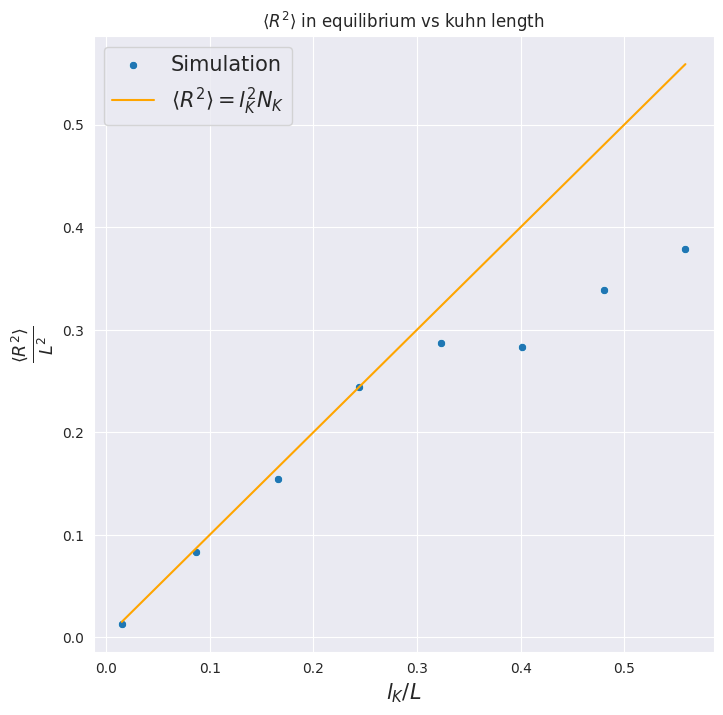

In [60]:
fig, ax = plt.subplots(figsize=(8,8))

sns.scatterplot(
    x=df_kuhn_summary["l_K"]/L_contour,
    y=df_kuhn_summary["R^2"]/L_contour**2,
    ax=ax,
    label="Simulation"
)

sns.lineplot(
    x=df_kuhn_summary["l_K"]/L_contour,
    y=(df_kuhn_summary["l_K"]**2 * N_Ks) / L_contour**2,
    label=r"$\langle R^2 \rangle = l_K^2 N_K$",
    color="orange"
)

ax.set(
    title=r"$\langle R^2 \rangle$ in equilibrium vs kuhn length",
    xlabel="$l_K / L$",
    ylabel=r"$\frac{\langle R^2 \rangle}{L^2}$"
)

ax.legend(fontsize=15)
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(18)

In [85]:
df_kuhn_summary["l_K"]**2 * df_kuhn_summary["N_K"] / df_kuhn_summary["R^2"]

kappa
1.0     1.173542
6.0     1.046387
11.0    1.074174
16.0    0.999357
21.0    1.122858
26.0    1.417562
31.0    1.419721
36.0    1.474517
dtype: float64

### ETE change $ \langle (\Delta R(t))^2 \rangle $

In [61]:
df_ete_change_kappas_equi = transform.calculate_ens_avg_df_ete_change_kappas(df_ete_kappas_equi)
df_ete_change_kappas_equi["l_K"] = kremer_grest.bare_kuhn_length(df_ete_change_kappas_equi["kappa"], l_b=l_b)
df_ete_change_kappas_equi

,dR^2,kappa,l_K
t,,,
30000000,0.000000,1.0,1.854017
30010000,21.326888,1.0,1.854017
30020000,31.856830,1.0,1.854017
30030000,38.892682,1.0,1.854017
30040000,50.576650,1.0,1.854017
...,...,...,...
30960000,583.677986,36.0,68.870000
30970000,567.112886,36.0,68.870000
30980000,604.678783,36.0,68.870000


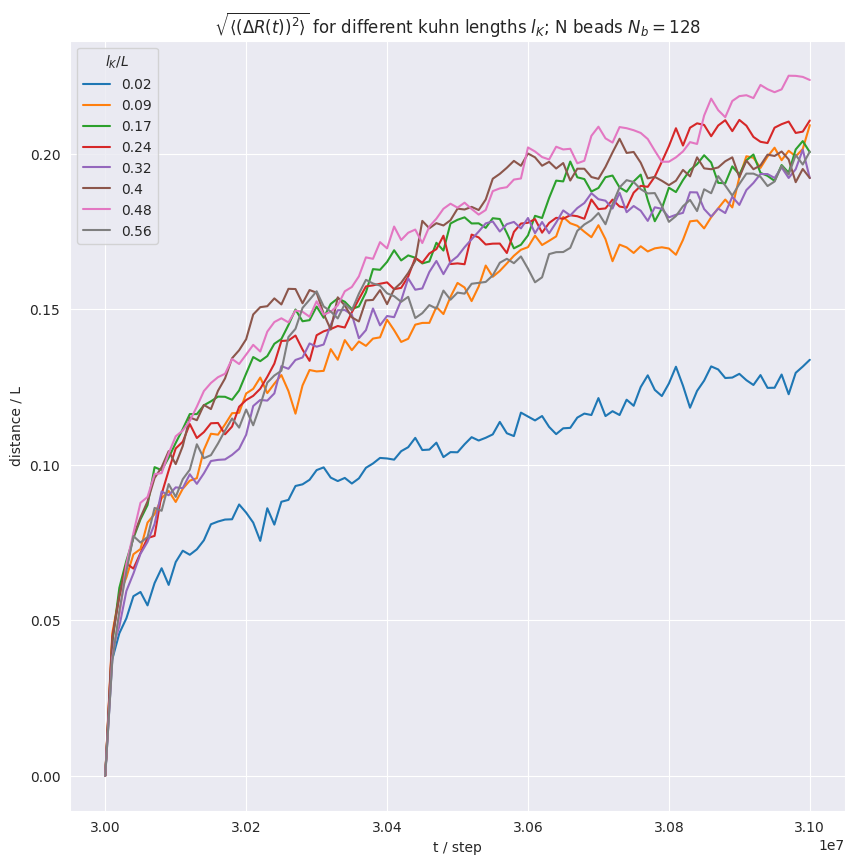

In [46]:
ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(10,10))
ax.set(
    title=f'$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} $ for different kuhn lengths $l_K$; '
          f'N beads $N_b={conf.system_creator_config.system_config.n_monomers}$',
    ylabel="distance / L",
    xlabel="t / step"
)

sns.lineplot(
    x=df_ete_change_kappas_equi.index.get_level_values("t"),
    y=np.sqrt(df_ete_change_kappas_equi["dR^2"]) / L_contour,
    hue=(df_ete_change_kappas_equi["l_K"]/L_contour).round(2).astype("category"),
    color=kappa_colors,
    ax=ax
)

ax.get_legend().set_title("$l_K/L$")

## Compare with Rouse model

### Transform time

In [67]:
df_ete_change_kappas_equi["t/LJ"] = df_ete_change_kappas_equi.index.get_level_values("t").map(lambda t: t*0.0025)
df_ete_change_kappas_equi["t/LJ rescaled"] = df_ete_change_kappas_equi["t/LJ"]-df_ete_change_kappas_equi["t/LJ"].min()
df_ete_change_kappas_equi

,dR^2,kappa,l_K,t/LJ,t/LJ rescaled
t,,,,,
30000000,0.000000,1.0,1.854017,75000.0,0.0
30010000,21.326888,1.0,1.854017,75025.0,25.0
30020000,31.856830,1.0,1.854017,75050.0,50.0
30030000,38.892682,1.0,1.854017,75075.0,75.0
30040000,50.576650,1.0,1.854017,75100.0,100.0
...,...,...,...,...,...
30960000,583.677986,36.0,68.870000,77400.0,2400.0
30970000,567.112886,36.0,68.870000,77425.0,2425.0
30980000,604.678783,36.0,68.870000,77450.0,2450.0


### Analytical $\tau_R$

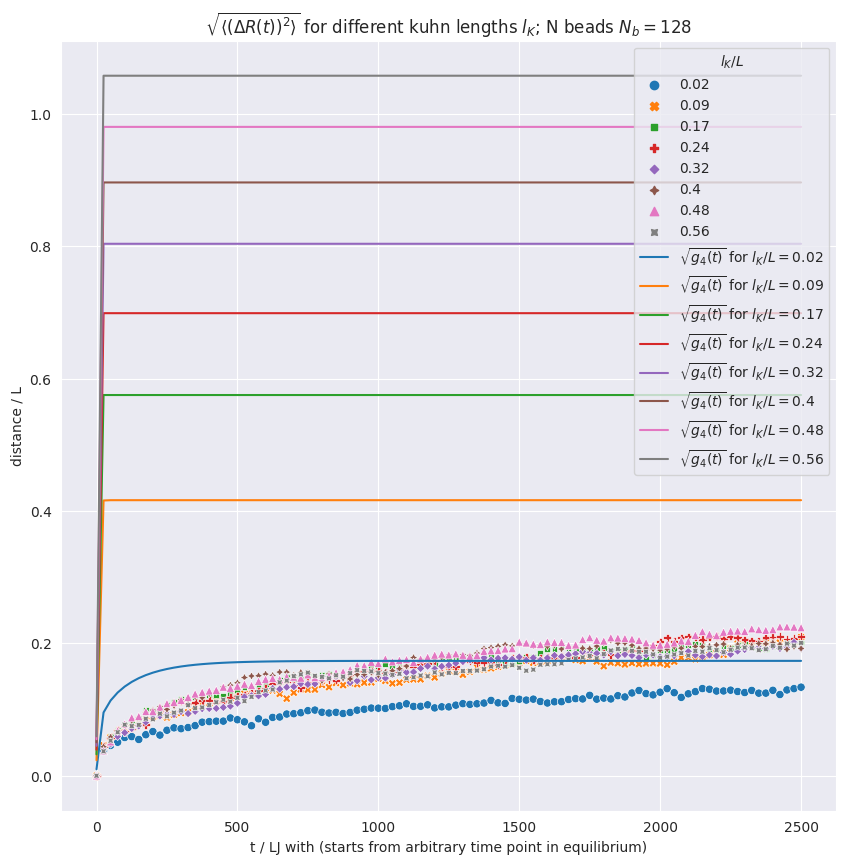

In [83]:
ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(10,10))
ax.set(
    title=f'$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} $ for different kuhn lengths $l_K$; '
          f'N beads $N_b={conf.system_creator_config.system_config.n_monomers}$',
    ylabel="distance / L",
    xlabel="t / LJ with (starts from arbitrary time point in equilibrium)"
)

sns.scatterplot(
    x=df_ete_change_kappas_equi["t/LJ rescaled"],
    y=np.sqrt(df_ete_change_kappas_equi["dR^2"]) / L_contour,
    hue=(df_ete_change_kappas_equi["l_K"]/L_contour).round(2).astype("category"),
    color=kappa_colors,
    style=(df_ete_change_kappas_equi["l_K"]/L_contour).round(2).astype("category"),
    ax=ax
)

for i, (l_K, N_K) in enumerate(zip(df_kuhn_summary["l_K"], df_kuhn_summary["N_K"])):
    ts = df_ete_change_kappas_equi["t/LJ rescaled"].unique()
    zeta = 1  # LJ
    tau_rouse = N_K ** 2 * l_b ** 2 * zeta / (3 * np.pi ** 2)
    rouse_predictions = rouse.rouse_g_4(
        t=ts,
        tau_R=tau_rouse,
        p_max=conf.system_creator_config.system_config.n_monomers,
        N_b=N_K,
        l_b=l_K
    )
    ax.plot(
        ts,
        np.sqrt(rouse_predictions) / L_contour,
        color=kappa_colors[i],
        label=f"$\sqrt{{g_4(t)}}$ for $l_K/L = {np.round(l_K/L_contour, 2)}$"
    )
ax.legend(loc='upper right')

ax.get_legend().set_title("$l_K/L$")

### Fit $\tau_R$

[4222.89391966] [[3024.13122036]]
[30925.4409726] [[440086.61408545]]
[84022.14899805] [[1158628.71925176]]
[179134.47464716] [[12247704.47528877]]
[381002.7452564] [[51437132.75692963]]
[448114.09858124] [[77856801.25050944]]
[528712.7894991] [[66473661.40585682]]
[1168838.36877338] [[4.28839926e+08]]


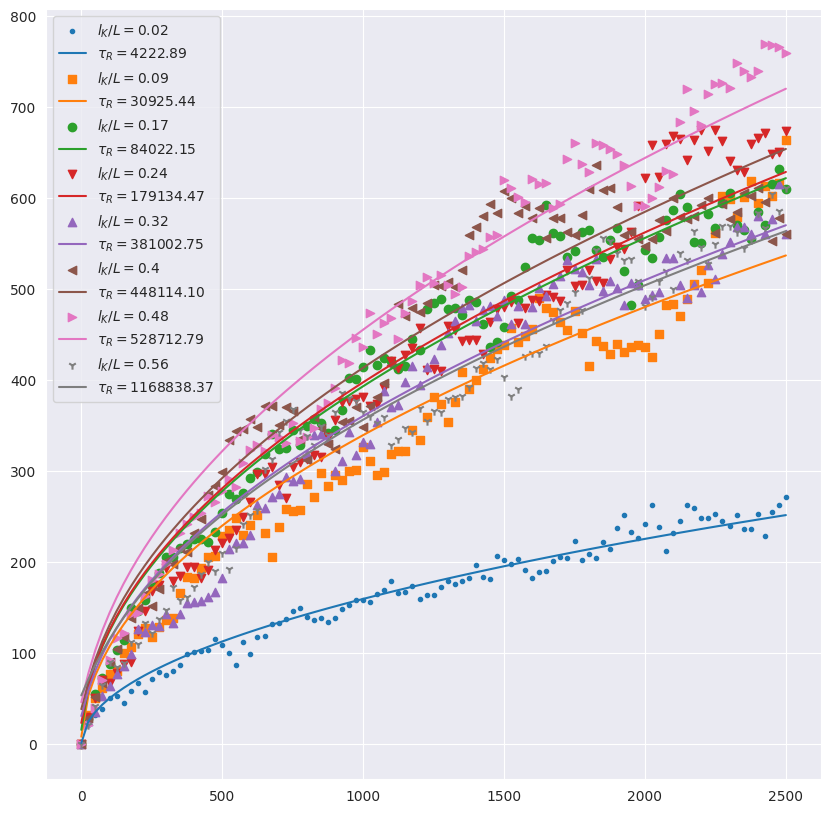

In [99]:
import matplotlib.markers

ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(10,10))

for i, (kappa, df_ete_change_kappas_equi_kappa) in enumerate(df_ete_change_kappas_equi.groupby("kappa")):
    l_K = df_kuhn_summary.loc[kappa]["l_K"]
    N_K = df_kuhn_summary.loc[kappa]["N_K"]
    popt, pcov = scipy.optimize.curve_fit(
        functools.partial(rouse.rouse_g_4, N_b=N_K, l_b=l_K, p_max=conf.system_creator_config.system_config.n_monomers),
        df_ete_change_kappas_equi_kappa["t/LJ rescaled"],
        df_ete_change_kappas_equi_kappa["dR^2"],
        p0=(10,)
    )
    print(popt, pcov)

    ax.scatter(
        df_ete_change_kappas_equi_kappa["t/LJ rescaled"],
        df_ete_change_kappas_equi_kappa["dR^2"],
        label=f"$l_K/L={np.round(l_K/L_contour, 2)}$",
        marker= list(matplotlib.markers.MarkerStyle.markers.keys())[i],
        color=kappa_colors[i]
    )
    ax.plot(
        df_ete_change_kappas_equi_kappa["t/LJ rescaled"],
        rouse.rouse_g_4(
            t=df_ete_change_kappas_equi_kappa["t/LJ rescaled"],
            N_b=N_K,
            l_b=l_K,
            p_max=conf.system_creator_config.system_config.n_monomers,
            tau_R=popt[0]
        ),
        label=f"$\\tau_R={popt[0]:.2f}$",
        color=kappa_colors[i]
    )

ax.legend()